<a href="https://colab.research.google.com/github/fvdias78/colab/blob/main/LSTM_CodeTrading_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e4e746729b261ab9d187b71d2de80f3e79e69be687cee557e3674f963844356a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:

import numpy as np

def recalcular_X(dataset_scaled, backcandles, nfeat):
    """
    Recalcula o array X a partir do dataset escalado, utilizando uma janela de tempo definida por backcandles.

    Args:
        dataset_scaled (np.ndarray): O dataset escalado, onde as linhas são instâncias de tempo e as colunas são os recursos (features).
        backcandles (int): O número de instâncias anteriores para incluir na janela de tempo.
        nfeat (int): O número de features no dataset (incluindo o valor preditivo e os indicadores).

    Returns:
        X (np.ndarray): O array de features formatado para o modelo, com a forma (n amostras, backcandles, nfeat).
        y (np.ndarray): O array de valores alvo (target) correspondente ao dataset escalado.
    """
    X = []

    # Recalcular X com os novos dados
    for j in range(nfeat):
        X.append([])
        for i in range(backcandles, dataset_scaled.shape[0]):
            X[j].append(dataset_scaled[i-backcandles:i, j])

    # Mover o eixo de volta à posição correta
    X = np.moveaxis(X, [0], [2])

    # Converter para numpy array
    X = np.array(X)

    # Extrair a coluna de valores alvo (última coluna)
    yi = np.array(dataset_scaled[backcandles:, -1])
    y = np.reshape(yi, (len(yi), 1))

    return X, y

In [ ]:

# ipython-input-4-435d314ec63a
def adicionar_nova_linha_g(X_test, next_pred_real, indicadores, sc_price, sc_resto, backcandles, nfeat):

    print(f"sxhape de X_test: {X_test.shape}")
    nova_linha = np.zeros((1, backcandles, nfeat))

    # Normalizar os indicadores
    #The indicadores array needs to be reshaped to be a 2D array before being transformed.
    # Verificando o shape do array de indicadores antes do transform
    indicadores_array = np.array([[indicadores['RSI'], indicadores['EMAF'], indicadores['EMAM'], indicadores['EMAS']]])
    #print(f"indicadores_array.shape: {indicadores_array.shape}")

    indicadores_norm = sc_resto.transform(indicadores_array)

    # Criar uma nova linha de valores normalizados
    nova_linha[0, backcandles-1, 0] = sc_price.transform(np.array([next_pred_real]).reshape(1, -1))
    nova_linha[0, backcandles-1, 1:] = indicadores_norm
    print(nova_linha)
    newline = np.concatenate((X_test, nova_linha), axis=0)
    #print(newline)
    # Concatenar a nova linha com o X_test
    X_test = newline

    return X_test

In [ ]:

# Função para calcular indicadores técnicos
def calcular_indicadores(close_prices):
    #rsi = ta.rsi(pd.Series(close_prices), length=15)
    #emaf = ta.ema(pd.Series(close_prices), length=20)
    #emam = ta.ema(pd.Series(close_prices), length=100)
    #emas = ta.ema(pd.Series(close_prices), length=150)

    if isinstance(close_prices, np.ndarray):
        close_prices = pd.Series(close_prices)


    rsi=ta.rsi(close_prices, length=15)
    emaf=ta.ema(close_prices, length=2)
    emam=ta.ema(close_prices, length=100)
    emas=ta.ema(close_prices, length=150)


    return pd.DataFrame({
        'RSI': rsi,
        'EMAF': emaf,
        'EMAM': emam,
        'EMAS': emas
    })

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
data = yf.download(tickers = 'BTC-USD', start = '2013-01-01')
data.head(10)

nfeat = 5

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Adding indicators


indicadores_df = calcular_indicadores(data['Close'])
data = pd.concat([data, indicadores_df], axis=1)

#data['RSI']=ta.rsi(data.Close, length=15)
#data['EMAF']=ta.ema(data.Close, length=20)
#data['EMAM']=ta.ema(data.Close, length=100)
#data['EMAS']=ta.ema(data.Close, length=150)

#data['Target'] = data['Adj Close']-data.Open
#data['Target'] = data['Target'].shift(-1)

#data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Open','High','Low','Volume', 'Close', 'Date'], axis=1, inplace=True)

In [ ]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,235.427002,50.019072,229.312807,288.640505,327.932773,257.321014
1,257.321014,58.174526,231.980256,288.020317,326.997518,234.824997
2,234.824997,49.315763,232.251183,286.966944,325.776690,233.843002
3,233.843002,48.967016,232.402785,285.914985,324.559025,243.610001
4,243.610001,52.543343,233.470139,285.077263,323.486853,236.326004
5,236.326004,49.757135,233.742126,284.111891,322.332404,240.283005
6,240.283005,51.261414,234.365067,283.243992,321.245657,243.779007
7,243.779007,52.604668,235.261633,282.462508,320.219609,244.533997
8,244.533997,52.904994,236.144715,281.711448,319.217151,235.977005
9,235.977005,49.124904,236.128743,280.805815,318.114632,238.891998


In [ ]:
#Target column Categories
#y =[1 if data.Open[i]>data.Close[i] else 0 for i in range(0, len(data))]
#yi = [data.Open[i]-data.Close[i] for i in range(0, len(data))]
#print(yi)
#print(len(yi))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

data_set_scaled = sc.fit_transform(data.dropna())

# Escalonador específico para a coluna do preço
sc_price = MinMaxScaler(feature_range=(0, 1))
sc_resto = MinMaxScaler(feature_range=(0, 1))
# Ajustando o escalonador com os valores da coluna de preços de fechamento
sc_price.fit(data[['Adj Close']].dropna())

data_resto = data[['RSI', 'EMAF', 'EMAM', 'EMAS']].dropna()

sc_resto.fit(data_resto)

print(f"O scaler foi ajustado com {sc_resto.n_features_in_} features.")

#data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled[7])

O scaler foi ajustado com 4 features.
[4.56739939e-04 5.04825576e-01 8.68107301e-05 6.33670584e-04
 1.15398148e-03 4.67100286e-04]


In [ ]:




# multiple feature from data provided to the model
X = []


#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(nfeat):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

3495
[[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
   1.27915246e-03]
  [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
   1.26397493e-03]
  [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
   1.24416305e-03]
  ...
  [1.15075547e-03 6.89496576e-01 5.95775358e-04 5.55901535e-04
   9.50343024e-04]
  [1.02701968e-03 6.11188915e-01 6.16897383e-04 5.58330130e-04
   9.45542437e-04]
  [9.79649661e-04 5.83244579e-01 6.31210197e-04 5.59643494e-04
   9.40063450e-04]]

 [[6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
   1.26397493e-03]
  [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
   1.24416305e-03]
  [3.20393089e-04 4.61078263e-01 4.50917981e-05 6.87568654e-04
   1.22440251e-03]
  ...
  [1.02701968e-03 6.11188915e-01 6.16897383e-04 5.58330130e-04
   9.45542437e-04]
  [9.79649661e-04 5.83244579e-01 6.31210197e-04 5.59643494e-04
   9.40063450e-04]
  [1.04151064e-03 6.07945867e-01 6.50425106e-04 5.62324439e-04
   9.35625996e-0

In [ ]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [ ]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2772
(2772, 30, 5)
[[[0.26844082 0.38695768 0.2967102  0.36241183 0.41783215]
  [0.2733122  0.41979181 0.29610673 0.36138276 0.41657069]
  [0.2635957  0.36910107 0.29457665 0.36015518 0.41517375]
  ...
  [0.26309344 0.43937833 0.28096737 0.33592789 0.38541007]
  [0.2603867  0.4137904  0.28055413 0.33513208 0.38437558]
  [0.25876715 0.39856684 0.28001622 0.33431554 0.38332943]]

 [[0.2733122  0.41979181 0.29610673 0.36138276 0.41657069]
  [0.2635957  0.36910107 0.29457665 0.36015518 0.41517375]
  [0.26530584 0.38120872 0.2933655  0.35899044 0.4138221 ]
  ...
  [0.2603867  0.4137904  0.28055413 0.33513208 0.38437558]
  [0.25876715 0.39856684 0.28001622 0.33431554 0.38332943]
  [0.26151795 0.431475   0.27980815 0.33357714 0.38234023]]

 [[0.2635957  0.36910107 0.29457665 0.36015518 0.41517375]
  [0.26530584 0.38120872 0.2933655  0.35899044 0.4138221 ]
  [0.25634038 0.33646682 0.29136168 0.35764679 0.41234791]
  ...
  [0.25876715 0.39856684 0.28001622 0.33431554 0.38332943]
  [0.26151795 0

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, nfeat), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 5.1339e-04 - val_loss: 0.0017
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 5.8231e-04 - val_loss: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 4.2967e-04 - val_loss: 6.8467e-04
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 3.7861e-04 - val_loss: 7.6233e-04
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 4.0196e-04 - val_loss: 6.2072e-04
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 3.2177e-04 - val_loss: 6.7028e-04
Epoch 8/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 3.7256e-04 - val_loss: 0.0012
Epoch 9/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 3.7654e-04 - val_loss: 0.0013
Epoch 10/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 3.2335e-04 - val_loss: 6.2443e-04
Epoch 11/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 2.61

In [ ]:
y_pred = model.predict(X_test)
#print(X_test[650])

#y_pred=np.where(y_pred > 0.43, 1,0)
#for i in range(0):
print(y_pred[-1], y_test[-1])

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[0.72175074] [0.75343311]


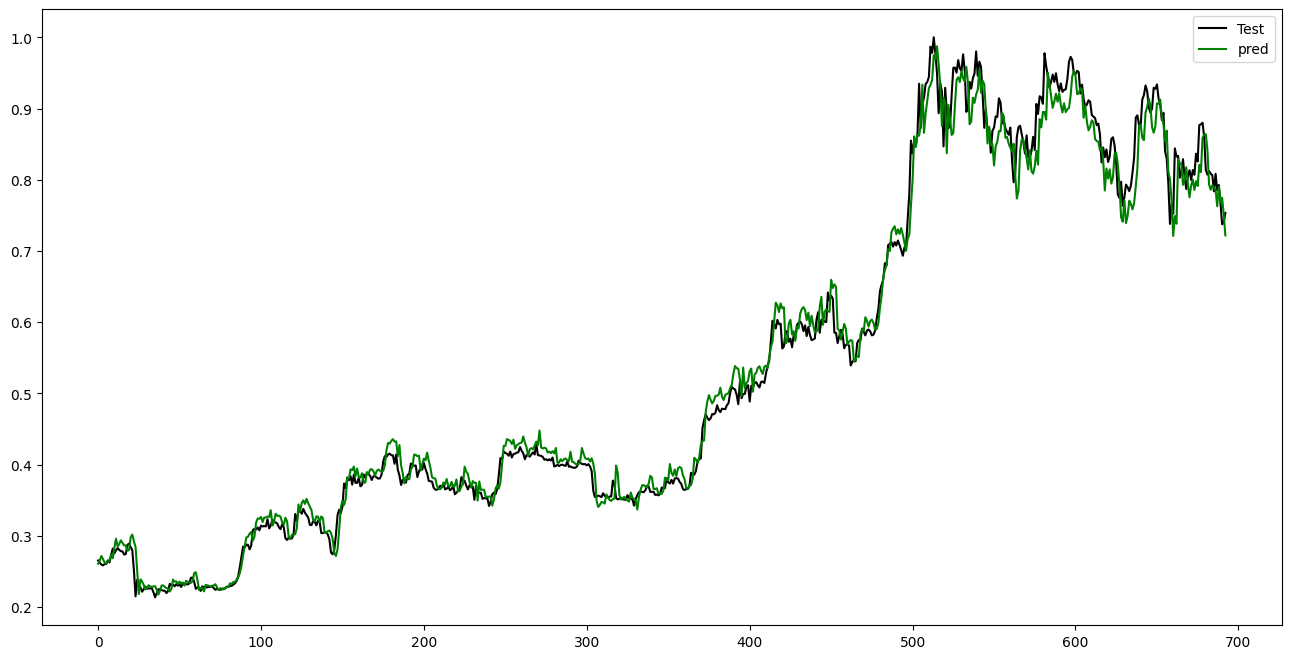

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [7.37423397e-01 3.00221127e-01 8.54743622e-01 9.54745814e-01
  9.83811830e-01 7.40043484e-01]
 [7.40043484e-01 3.07961348e-01 8.48264207e-01 9.52501765e-01
  9.82364633e-01 7.53433109e-01]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 4.10388136e-02
  9.54979531e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [7.40043484e-01 3.07961348e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 4.06559948e-02
  9.45303860e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 4.02807566e-02
  9.35756343e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.99129489e-02
  9.26335283e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.95524244e-02
  9.17039006e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.91990391e-02
  9.07865858e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.88526515e-02
  8.98814208e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.88526515e-02
  8.98814208e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.85131230e-02
  8.89882448e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.81803179e-02
  8.81068990e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.85131230e-02
  8.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.81803179e-02
  8.81068990e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.78541030e-02
  8.72372266e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.75343478e-02
  8.63790730e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.78541030e-02
  8.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.72209244e-02
  8.55322857e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.69137074e-02
  8.46967142e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.66125739e-02
  8.38722098e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.66125739e-02
  8.38722098e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.63174034e-02
  8.30586260e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.60280779e-02
  8.22558181e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.60280779e-02
  8.22558181e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.57444816e-02
  8.14636435e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.54665011e-02
  8.06819612e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.57444816e-02
  8.14636435e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.54665011e-02
  8.06819612e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.51940251e-02
  7.99106324e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.51940251e-02
  7.99106324e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.49269447e-02
  7.91495198e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.46651530e-02
  7.83984882e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.49269447e-02
  7.91495198e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.46651530e-02
  7.83984882e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.44085454e-02
  7.76574040e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.46651530e-02
  7.83984882e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.44085454e-02
  7.76574040e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.41570190e-02
  7.69261355e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.44085454e-02
  7.76574040e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.41570190e-02
  7.69261355e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.39104734e-02
  7.62045527e-02 0.00000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.41570190e-02
  7.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.39104734e-02
  7.62045527e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.36688099e-02
  7.54925273e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.34319318e-02
  7.47899327e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.36688099e-02
  7.54925273e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.34319318e-02
  7.47899327e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.31997443e-02
  7.40966439e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.34319318e-02
  7.47899327e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.31997443e-02
  7.40966439e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.29721546e-02
  7.34125378e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.31997443e-02
  7.40966439e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.29721546e-02
  7.34125378e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.27490716e-02
  7.27374927e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[[0.01951065]]
[[3.42129528e-04 4.73730554e-01 0.00000000e+00 7.30117884e-04
  1.27915246e-03 6.42570171e-04]
 [6.42570171e-04 5.71810075e-01 3.89258585e-05 7.20435871e-04
  1.26397493e-03 3.33868513e-04]
 [3.33868513e-04 4.65272382e-01 4.28794852e-05 7.03991230e-04
  1.24416305e-03 3.20393089e-04]
 ...
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.29721546e-02
  7.34125378e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.27490716e-02
  7.27374927e-02 0.00000000e+00]
 [1.95106510e-02 6.36600108e-01 2.04736017e-02 3.25304062e-02
  7.20713886e-02 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


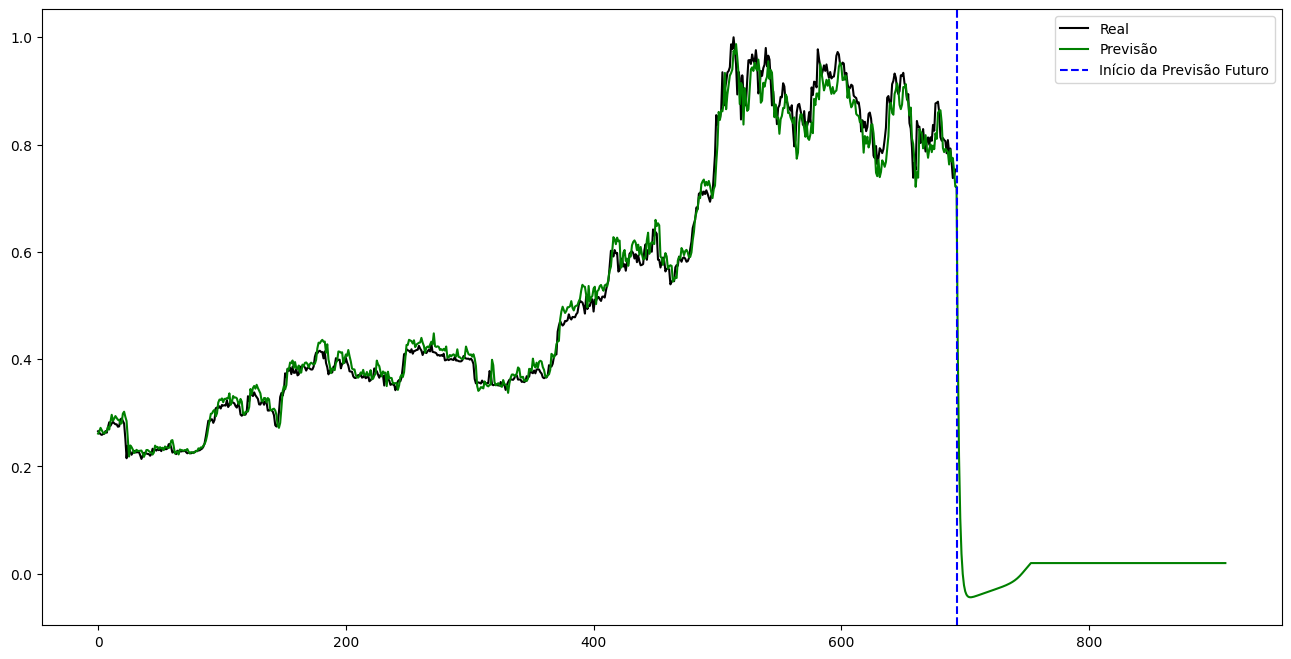

In [ ]:

# Iteração para prever novos valores e recalcular indicadores
future_days = 30

#print(X_test.shape)


#y_test_expanded = np.repeat(y_test[:, np.newaxis, :], X_test.shape[1], axis=1)

# Verifique as formas de X_test e y_test
#print(f"Shape de X_test: {X_test.shape}")  # (n_samples, timesteps, features)
#print(f"Shape de y_test: {y_test.shape}")  # (n_samples, 1)
# Verifique a nova forma de y_test_expanded
#print(f"Shape de y_test_expanded: {y_test_expanded.shape}")  # (693, 30, 1)

# Agora, você pode concatenar ao longo do eixo 2 (o eixo das features)
#future = np.concatenate((X_test, y_test_expanded), axis=2)

# Verifique o resultado
#print(f"Shape do futuro concatenado: {future.shape}")

#print(len(future))
#print(len(X_future))


for i in range(future_days):
    # Fazer previsão para o próximo dia
    # Pegue apenas os últimos 'backcandles' time steps para manter a forma correta
    #future_subset = future[-backcandles:, :nfeat].copy()


    # Verifique a forma de future_subset antes de redimensionar
    #print(f"Shape de future_subset antes de reshape: {future_subset.shape}")

    #print(X_test)
    next_pred = model.predict(X_test[-1].reshape(1, backcandles, nfeat))
    next_pred_price = sc_price.inverse_transform(next_pred.reshape(-1, 1)).flatten()[0]
    #print(f"preco em escala {next_pred}")

    #print(f"preco real {next_pred_price}")

    # Armazene as previsões
    y_pred = np.append(y_pred, next_pred)

    y_pred_real = sc_price.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    #print(f" valores previstos real {y_pred_real}")

    #print(f"y_pred_real.shape {y_pred_real.shape}")
    # Recalcula os indicadores usando a função encapsulada
    indicadores = calcular_indicadores(y_pred_real).iloc[-1,:]
    #print(indicadores.iloc[-1,:])

    # Re-normalizar e atualizar as colunas apropriadas

    print(next_pred)


    indicadores_array = np.array([[indicadores['RSI'], indicadores['EMAF'], indicadores['EMAM'], indicadores['EMAS']]])    #print(f"indicadores_array.shape: {indicadores_array.shape}")

    indicadores_norm = sc_resto.transform(indicadores_array)
    novos_valores = np.concatenate((np.array(next_pred).reshape(1) , indicadores_norm.flatten(), np.zeros(1)))
    data_set_scaled = np.vstack([data_set_scaled, novos_valores])
    print(data_set_scaled)


    # Criar uma nova linha de valores normalizados
    #nova_linha[0, backcandles-1, 0] = sc_price.transform(np.array([next_pred_real]).reshape(1, -1))
    #X_test = adicionar_nova_linha_g(X_test, next_pred_price,  indicadores.iloc[-1,:], sc_price, sc_resto, backcandles, nfeat)

# Comparar previsões com dados reais
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_test)), y_test, color='black', label='Real')
plt.plot(np.arange(len(y_pred)), y_pred, color='green', label='Previsão')
plt.axvline(x=len(y_test), color='blue', linestyle='--', label='Início da Previsão Futuro')
plt.legend()
plt.show()